In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score

In [2]:
df = pd.read_csv("data_with_junk_food_solid.csv")
df_numeric = df.drop(columns=["Food code", "Main food description", "WWEIA Category description"
                              , "WWEIA Category number", "Is Liquid"])

X = df_numeric.drop(columns=["Junk Food"])
y = df_numeric["Junk Food"]

In [3]:
df["Junk Food"].value_counts()

0    4358
1     114
Name: Junk Food, dtype: int64

In [4]:
def dummy_classifier(X_train, y_train, X_test, y_test):
    preA, recA, accA, preB, recB, accB = None, None, None, None, None, None
    from sklearn.dummy import DummyClassifier
    from sklearn.metrics import accuracy_score, precision_score, recall_score

    d_classifier = DummyClassifier(strategy="stratified", random_state = 0).fit(X_train, y_train)
    d_y_pred = d_classifier.predict(X_test) 

    return classification_report(y_test, d_y_pred)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
print('Dummy classifier report: Solid')
print(dummy_classifier(X_train, y_train, X_test, y_test))

Dummy classifier report: Solid
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       873
           1       0.00      0.00      0.00        22

    accuracy                           0.95       895
   macro avg       0.49      0.49      0.49       895
weighted avg       0.95      0.95      0.95       895



In [7]:
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

y_pred = gb_model.predict(X_test_scaled)

In [8]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(report)

Accuracy: 0.9978
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       873
           1       1.00      0.91      0.95        22

    accuracy                           1.00       895
   macro avg       1.00      0.95      0.98       895
weighted avg       1.00      1.00      1.00       895



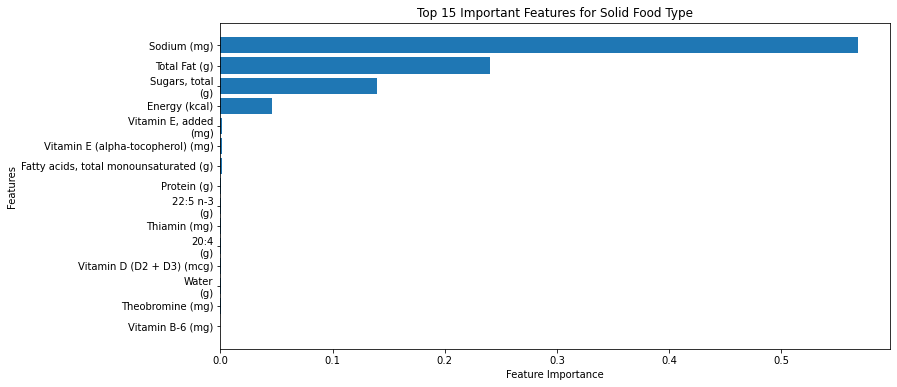

In [9]:
# Feature importance
feature_importance = gb_model.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feat_imp_df['Feature'][:15], feat_imp_df['Importance'][:15])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 15 Important Features for Solid Food Type")
plt.gca().invert_yaxis()
plt.show()

In [10]:
# Ablation Study
ablation_results = []
sorted_features = feat_imp_df['Feature'].tolist()[::-1]
X_train_ablate = X_train_scaled.copy()
X_test_ablate = X_test_scaled.copy()

for i in range(0, len(sorted_features), 5):
    if i > 0:
        features_to_remove = sorted_features[:i]
        feature_indices = [X.columns.get_loc(f) for f in features_to_remove]
        X_train_ablate = np.delete(X_train_scaled, feature_indices, axis=1)
        X_test_ablate = np.delete(X_test_scaled, feature_indices, axis=1)

    gb_model_ablate = GradientBoostingClassifier(n_estimators=100, random_state=42)
    gb_model_ablate.fit(X_train_ablate, y_train)
    
    y_pred_ablate = gb_model_ablate.predict(X_test_ablate)
    accuracy_ablate = accuracy_score(y_test, y_pred_ablate)
    f1_ablate = f1_score(y_test, y_pred_ablate, average='weighted')
    ablation_results.append({"Removed Features": sorted_features[i], "Accuracy": accuracy_ablate, "F1 Score": f1_ablate})

ablation_df = pd.DataFrame(ablation_results)
print(ablation_df.sort_values(by="Accuracy", ascending=False))

                          Removed Features  Accuracy  F1 Score
2                              Alcohol (g)  0.998883  0.998870
4                                12:0\n(g)  0.998883  0.998870
5                              Niacin (mg)  0.998883  0.998870
7                                18:0\n(g)  0.998883  0.998870
0   Fatty acids, total polyunsaturated (g)  0.997765  0.997713
1               Vitamin B-12, added\n(mcg)  0.997765  0.997713
3                           Selenium (mcg)  0.997765  0.997713
6                               Zinc\n(mg)  0.997765  0.997713
8                 Vitamin A, RAE (mcg_RAE)  0.997765  0.997713
9                                14:0\n(g)  0.997765  0.997713
10                        Vitamin B-6 (mg)  0.997765  0.997713
11                            Thiamin (mg)  0.997765  0.997713
12                  Vitamin E, added\n(mg)  0.997765  0.997713


In [ ]:
# Sensitivity Analysis
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

In [ ]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)
best_accuracy = accuracy_score(y_test, y_pred_best)

print("Best Hyperparameters:", best_params)
print(f"Best Model Accuracy: {best_accuracy:.4f}")

print("Classification Report:\n", classification_report(y_test, y_pred_best))

In [ ]:
# Failure analysis
df_test = X_test.copy()
df_test['Actual'] = y_test.values
# df_test['Predicted'] = y_pred
df_test['Predicted'] = y_pred_best

misclassified = df_test[df_test['Actual'] != df_test['Predicted']]

misclassification_counts = misclassified.groupby(['Actual', 'Predicted']).size().reset_index(name='Count')

print("Misclassified Samples:")
print(misclassified)

print("\nMisclassification Counts for solid food type:")
print(misclassification_counts)